### Evasion dataset 

In [469]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import unidecode, re
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from scipy import *
from sklearn.feature_selection import SelectKBest, f_regression
from catboost import CatBoostClassifier

In [470]:
# configs 
my_font = dict(
            family="Courier New, monospace",
            size=18,
            color="Black",
            variant="small-caps",
) 

In [471]:
active = pd.read_csv('data/alunos_ativos.csv')
deactive = pd.read_csv('data/alunos_inativos.csv')
history = pd.read_csv('data/historico_escolar.csv')

# Choose what to see 

In [472]:
datasets = [deactive, active]

for i in datasets:
    df_test = i.copy()
    df_test['Data ocorrência'] = pd.to_datetime(df_test['Data ocorrência'])
    df_test['Data Nascimento']= pd.to_datetime(df_test['Data Nascimento'])

    filtered = (df_test['Período'] / 10).astype(int)
    filtered = pd.to_datetime(filtered, format='%Y', errors='coerce')
    
    i['Data ocorrência'] = np.where(
        df_test['Data ocorrência'].isna(),
        filtered,
        df_test['Data ocorrência']
    )
        
    df_test['Difference'] = ((i['Data ocorrência'] - df_test['Data Nascimento']).dt.days / 365.0)
    i.loc[:,'Idade'] = df_test['Difference']

    
finished = deactive[deactive['Situação atual'] == 'EXCLUSAO POR CONCLUSAO (FORMADO)']
dropout = deactive[deactive['Situação atual'] != 'EXCLUSAO POR CONCLUSAO (FORMADO)']


In [473]:
# Normalizing names from Naturalidade column

def normalize_names(text):
    if pd.isnull(text):
        return text
    text = str(text)
    text = unidecode.unidecode(text)
    text = text.lower().strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = text.title()
    return text


## Correcting mispelled cities

In [474]:
corrected_cities = {
    'Barra Do Garcas  Mt': 'Barra Do Garcas',
    'Canabravamg': 'Cana Brava',  
    'Baliza Go' : 'Baliza' ,
    'Rondonopolitano': 'Rondonopolis',
    'Braganca Pa': 'Braganca',
    'Aragarcasgo': 'Aragarcas',
    'Nova Xavantina  Mt': 'Nova Xavantina',
    'BARRA DO GARCAS - MT': 'Barra Do Garcas',
    'alta floresta - MT': 'Alta Floresta',
    'Cuiabamt': 'Cuiaba',
    'Palmitossc': 'Palmitos',
    'Vazante Mg': 'Vazante',
    'Jussarago': 'Jussara',
    'Rio Branco  Mt': 'Rio Branco',
    'Mato Grossointerior': 'Mato Grosso',
    'Chapecosc': 'Chapeco',
    'Agua Boamt': 'Agua Boa',
    'Alta Floresta  Mt': 'Alta Floresta',
    'Sao Joaquim Sc': 'Sao Joaquim',
    'Barra Do Garcas - Mt': 'Barra Do Garcas',
    'ARAGARÇAS': 'Aragarcas',
    'BARRA DO GARÇAS': 'Barra do Garcas'
}
datasets = [deactive, dropout, active, finished]

for df in datasets:
    df.loc[:,'Naturalidade'] = df['Naturalidade'].apply(normalize_names)

    df.loc[:,'Naturalidade']  = df['Naturalidade'].replace(corrected_cities)

## Group comparasion Finished vs Dropout


In [475]:
x = pd.concat([
        finished.assign(dataset="Finished"),
        dropout.assign(dataset="Deactive")])

px.box(x, x='Raça', y='Coeficiente', color='dataset').update_layout(title={"text": "GPA: Undergrads vs Dropout per Ethnics"}, font=my_font).show()
px.box(x, x='Sexo', y='Coeficiente', color='dataset').update_layout(title={"text": "GPA: Undergrads vs Dropout per Sex"}, font=my_font).show()
px.box(x, x='Tipo ingresso', y='Coeficiente', color='dataset').update_layout(title={"text": "GPA: Undergrads vs Dropout per Application "}, font=my_font).show()


In [476]:
px.pie(
    x, 
    names='Tipo ingresso', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Application "},font=my_font).show()

px.pie(
    x, 
    names='Raça', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Ethinic "},font=my_font).show()


px.pie(
    x, 
    names='Sexo', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Sexo "},font=my_font).show()


px.pie(
    x, 
    names='Nacionalidade', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Nacionality "},font=my_font).show()

In [477]:
x_grouped =  finished.groupby(['Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
y_grouped =  dropout.groupby(['Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
px.histogram(x_grouped.head(), x='Naturalidade', y='count', color='Naturalidade').update_layout(title={"text": "Undergrads"}, font=my_font).show()
px.histogram(y_grouped.head(), x='Naturalidade', y='count', color='Naturalidade').update_layout(title={"text": "Dropout"}, font=my_font).show()


In [478]:
x_grouped =  finished.groupby(['UF Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
y_grouped =  dropout.groupby(['UF Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
px.pie(x_grouped.head(), names='UF Naturalidade', values='count', color='UF Naturalidade').update_layout(title={"text": "Undergrads: Origin State"}, font=my_font).show()
px.pie(y_grouped.head(), names='UF Naturalidade', values='count', color='UF Naturalidade').update_layout(title={"text": "Dropout: Origin State"}, font=my_font).show()


## Analysing the years of entrance

In [479]:
x = pd.concat([
        finished.assign(dataset="Finished"),
        dropout.assign(dataset="Deactive")])

test = x.copy()
# extracting the year of entrance
test = test[test['Período ingresso'] != 0]  # removing those with Período de Ingresso is zero 

test['Ano Ingresso'] = (test['Período ingresso'] / 10).astype("int")

x['Ano Ingresso'] = test['Ano Ingresso']

y = x.groupby(['Ano Ingresso', 'Sexo', 'dataset']).size().reset_index(name='count').sort_values(by='count', ascending=False)
y = y[y['Ano Ingresso'] != 0] # making sure there are not the 22 zero values messing up the plot 
px.histogram(y, x='dataset', y='count', color='dataset').update_layout(bargap=0.5).update_layout(bargap=0.5, title={"text": "Amount of Finished vs dropouts"}, font=my_font).show()
px.histogram(y, x='Ano Ingresso', y='count', color='dataset').update_layout(bargap=0.5, title={"text": "Year of Entry Finished vs Dropouts"}, font=my_font).update_xaxes(tickmode='linear',dtick=1).show()


## Average time which someone evades

In [480]:
# let us do the math: If we subtract the period the person entered with the current period of the person, 
# we can get how much time they have spent in college 
test = test.dropna(subset=['Data ocorrência'])

test['Data ocorrência'] = test['Data ocorrência'].astype(str)

test['Ano atual']  = np.where (
    test['Data ocorrência'].isnull(),
    (test['Período'] /10), 
     test['Data ocorrência'].str[:4].astype(float)) 
test['Ano atual'] = test['Ano atual'].fillna(0).astype(int)

test['Tempo medio'] = test['Ano atual'] - test['Ano Ingresso']

mean_time = test.groupby('dataset')['Tempo medio'].mean().reset_index()
min_time = test.groupby('dataset')['Tempo medio'].min().reset_index()
max_time = test.groupby('dataset')['Tempo medio'].max().reset_index()
median_time = test.groupby('dataset')['Tempo medio'].median().reset_index()


px.bar(mean_time, x='dataset', y='Tempo medio', color='dataset').update_layout(bargap=0.5, title={"text": "Average time to quit"}, font=my_font).show()
px.bar(max_time, x='dataset', y='Tempo medio', color='dataset').update_layout(bargap=0.5, title={"text": "Max time to quit"}, font=my_font).show()
px.bar(median_time, x='dataset', y='Tempo medio', color='dataset').update_layout(bargap=0.5, title={"text": "Median time to quit"}, font=my_font).show()


In [481]:
px.pie(test,
      names='Tempo medio',
      color='Tempo medio',
      facet_col='dataset').update_layout(bargap=0.5, title={"text": "Distribution of Finished vs dropouts"}, font=my_font).show()

In [482]:
y = test.groupby(['Sexo', 'dataset']).mean('Tempo medio').reset_index()
y

,Sexo,dataset,Período,Estrutura,Período ingresso,IMI,Coeficiente,Idade,Ano Ingresso,Ano atual,Tempo medio
0,Feminino,Deactive,20177.462963,20131.740741,20144.370370,15.992593,2.509630,24.454845,2014.333333,2017.870370,3.537037
1,Feminino,Finished,20155.733333,20097.666667,20115.000000,59.593333,6.804000,24.598721,2011.400000,2016.133333,4.733333
2,Masculino,Deactive,20173.295820,20121.868167,20135.996785,12.778135,2.320096,25.627802,2013.498392,2017.408360,3.909968
3,Masculino,Finished,20167.614583,20117.041667,20125.062500,75.196875,6.341354,24.466267,2012.406250,2017.218750,4.812500


## Analysing the history

In [483]:
df_merged = pd.merge(test, history, how='right', on='rga_anonimo')
second = df_merged.copy()
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19528 entries, 0 to 19527
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Data Nascimento       14038 non-null  object 
 1   Sexo                  14038 non-null  object 
 2   Raça                  14038 non-null  object 
 3   Estrangeiro           14038 non-null  object 
 4   Nacionalidade         14038 non-null  object 
 5   Naturalidade          13796 non-null  object 
 6   UF Naturalidade       13126 non-null  object 
 7   Período               14038 non-null  float64
 8   Situação atual        14038 non-null  object 
 9   Data ocorrência       14038 non-null  object 
 10  Estrutura             14038 non-null  float64
 11  Período ingresso      14038 non-null  float64
 12  Tipo ingresso         14038 non-null  object 
 13  IMI                   14038 non-null  float64
 14  Coeficiente           14038 non-null  float64
 15  Tipo de demanda    

In [484]:
diciplines_grouped = df_merged[df_merged['SF'] == 'AP'] \
    .groupby(['dataset', 'Disciplina']) \
    .size() \
    .reset_index(name='count')\
    .sort_values( by='count', ascending=False)
px.histogram(diciplines_grouped, x='Disciplina', y='count', facet_col='dataset').update_layout(title={"text": "Disciplines Not failed"}, font=my_font) 


In [485]:
misses_avg = (
    df_merged.groupby("Ano")["FA"]
    .mean()
    .reset_index()
    .rename(columns={"FA": "avg_misses"})
)

cr_avg = (
    df_merged.groupby("Ano")["CR"]
    .mean()
    .reset_index()
    .rename(columns={"CR": "CR_avg"}) 
)

merged_2 = pd.merge(cr_avg, misses_avg, on='Ano')

merged_long = merged_2.melt(
    id_vars="Ano",
    value_vars=["avg_misses", "CR_avg"],
    var_name="Métrica",
    value_name="Valor"
)

px.line(
    merged_long,
    x="Ano",
    y="Valor",
    color="Métrica",
    markers=True,
    title="Missed classes against performance coeficient"
).update_layout(font=my_font).show()


In [486]:
df_merged["Failing"] = df_merged["SF"].isin(["RM", "RMF"]).astype(int)

df_merged["Pass"] = (df_merged["SF"] == "AP").astype(int)


In [487]:
# px.imshow(df_with_fails.corr(numeric_only=True), text_auto=True).show()

In [488]:
px.imshow(df_merged.corr(numeric_only=True), text_auto=True).show()

# From this it is possible to know the total amount of approved/failed subject for each student

In [489]:
reprovations = df_merged.groupby('rga_anonimo').agg(
        total_failings=('Failing', 'sum'),
        total_passes=('Pass', 'sum')      
)
reprovations['total_subjects_made'] = reprovations['total_failings'] + reprovations['total_passes']

In [490]:
x = reprovations.copy()
x['average_failing'] = ( reprovations['total_failings'] / reprovations['total_subjects_made'] ) * 100
x['average_passing'] = ( reprovations['total_passes'] / reprovations['total_subjects_made'] ) * 100


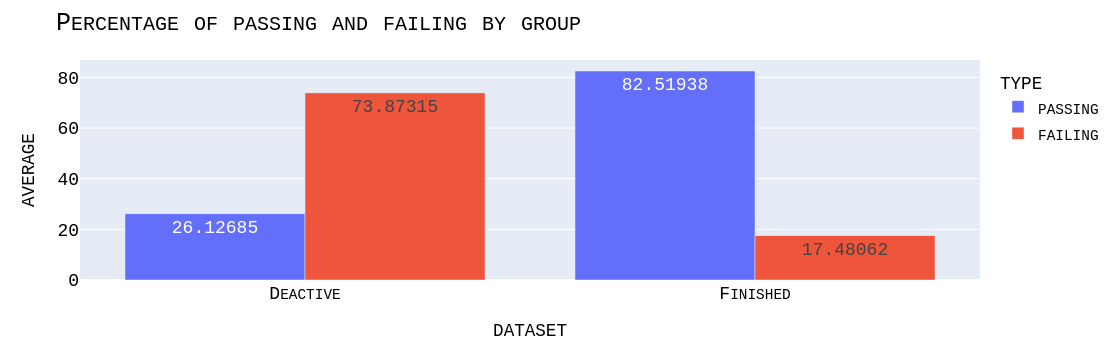

In [491]:
everyone_grouped = pd.merge(
    df_merged[['rga_anonimo', 'dataset', 'Sexo']].drop_duplicates(),
    x,
    on='rga_anonimo',
    how='inner'
)
y = everyone_grouped.groupby("dataset").agg( group_average_passing = ('average_passing', 'mean'),
                                             group_average_failing = ('average_failing', 'mean')).reset_index()
y_melted = y.melt(id_vars="dataset",
                  value_vars=["group_average_passing", "group_average_failing"],
                  var_name="type",
                  value_name="average")

y_melted["type"] = y_melted["type"].str.replace("group_average_", "")

px.bar(
    y_melted,
    x="dataset",
    y="average",
    color="type",
    barmode="group",
    text_auto=True
).update_layout(title={'text': 'Percentage of passing and failing by group'}, font=my_font).show()

## Now analysing the this percentage for each individual group like:
    - Gender
    - Quotas

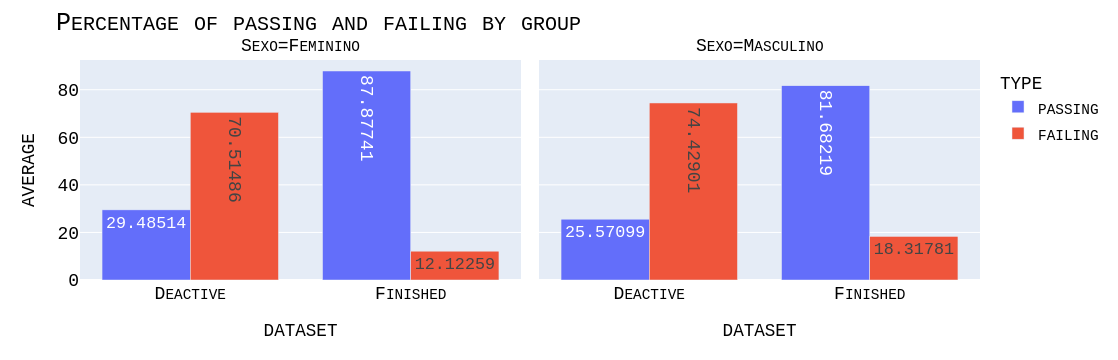

In [492]:
y = everyone_grouped.groupby(["Sexo","dataset"]).agg( group_average_passing = ('average_passing', 'mean'),
                                             group_average_failing = ('average_failing', 'mean')).reset_index()
y_melted = y.melt(id_vars=["Sexo", "dataset"],
                  value_vars=["group_average_passing", "group_average_failing"],
                  var_name="type",
                  value_name="average")

y_melted["type"] = y_melted["type"].str.replace("group_average_", "")

px.bar(
    y_melted,
    x="dataset",
    y="average",
    color="type",
    barmode="group",
    facet_col='Sexo',
    text_auto=True
).update_layout(title={'text': 'Percentage of passing and failing by group'}, font=my_font).show()

In [493]:
new = pd.merge(second, everyone_grouped, how='inner', on='rga_anonimo')
y = new.groupby(['Ano', 'Sexo_x'])['average_failing'].mean().reset_index()
px.line(y, x='Ano', y='average_failing', color='Sexo_x').update_layout(title={"text": 'Average Failing per year and sex'}, font=my_font)

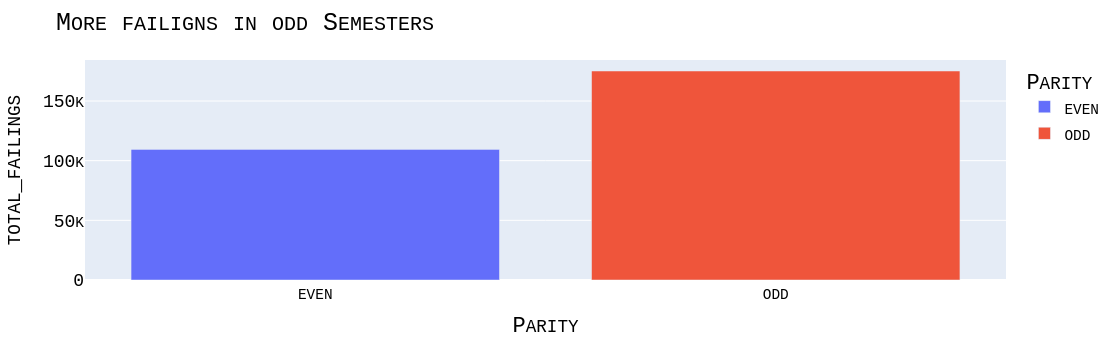

In [494]:
old = new.copy()
old['Semester'] = old['Ano'].str.split("/").str[1].astype(int)
old['Parity'] = old['Semester'] % 2
old['Parity'] = old['Parity'].map({0: "even", 1: "odd"})
x = old.groupby('Parity')['total_failings'].sum().reset_index()
px.bar(x, x='Parity', y='total_failings', color='Parity').update_layout(title = {"text": "More failigns in odd Semesters"}, font=my_font).show()

## Total Amount of Evasion x Entrance per year

In [495]:
x = pd.concat([
        finished.assign(dataset="Finished"),
        dropout.assign(dataset="Deactive"),
        active.assign(dataset="Active")])

y = x.copy()
y = y[y['Período ingresso'] != 0]  # removing those with Período de Ingresso is zero 
y['Ano Ingresso'] = (y['Período ingresso'] / 10).astype("int")



In [496]:
y['Data ocorrência'] = pd.to_datetime(y['Data ocorrência'])

y['AnoEvento'] = np.where (
    y['dataset'] == 'Deactive',
    y['Data ocorrência'].dt.to_period('Y'),
    np.where(
        y['dataset'] == 'Finished',
        y['Data ocorrência'].dt.to_period('Y'),
        np.where(
            y['dataset'] == 'Active',
            y['Data ocorrência'].dt.to_period('Y'),
            np.nan
        )
    )
)
y['AnoEvento'] = y['AnoEvento'].fillna(y['Período'] / 10)


megazord = y.copy()


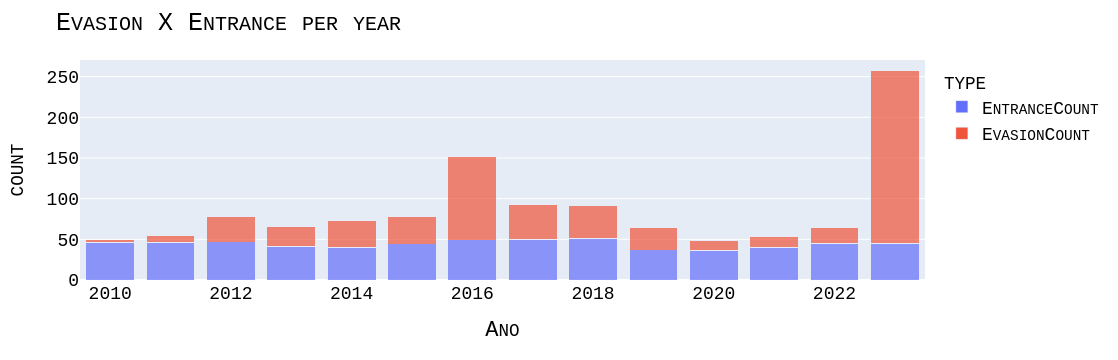

In [497]:
entrance_counts = y.groupby(['Ano Ingresso']).size().reset_index(name='EntranceCount')
leaving_counts = y.groupby(['AnoEvento']).size().reset_index(name='EvasionCount')


entrance_counts.rename(columns={'Ano Ingresso': 'Ano'}, inplace=True)
leaving_counts.rename(columns={'AnoEvento': 'Ano'}, inplace=True)
leaving_counts['Ano'] = leaving_counts['Ano'].dt.year
leaving_counts['Ano'] = leaving_counts['Ano'].astype(int)


counts = pd.merge(entrance_counts, leaving_counts, on='Ano', how='inner')

counts_long = counts.melt(
    id_vars="Ano",
    value_vars=["EntranceCount", "EvasionCount"],
    var_name="type", value_name="count"
)

px.bar(counts_long, x="Ano", y="count", color="type", barmode="stack", opacity=0.7).update_layout(title={"text": "Evasion X Entrance per year"}, font=my_font).show()


## Student's t-Test (independent) → compare average performance coefficient between dropouts and graduates.

In [498]:
history_modified = history.copy()
history_modified.drop(columns={ "Código", "Ano", "Nome da Disciplina", "TU", "SE" ,"MF", "Disciplina", 
                               "Grupo de Disciplinas", "Optativa", "Tipo de Disciplina", "Código"}, inplace=True)
history_modified["Failing"] = history_modified["SF"].isin(["RM", "RMF"]).astype(int)

history_modified["Pass"] = (history_modified["SF"] == "AP").astype(int)

x = history_modified.groupby('rga_anonimo').agg(
        total_failings=('Failing', 'sum'),
        total_passes=('Pass', 'sum'),
        average_cr=('CR', 'mean')
)
x['total_subjects_made'] = x['total_failings'] + x['total_passes']
x['average_failing'] = ( x['total_failings'] / x['total_subjects_made'] ) * 100
x['average_passing'] = ( x['total_passes'] / x['total_subjects_made'] ) * 100
x

,total_failings,total_passes,average_cr,total_subjects_made,average_failing,average_passing
rga_anonimo,,,,,,
005f0115277a00616dc1f82d6a8ab0dcab6dc9c9f5fc324bc89114111235b6f8,27,4,5.354839,31,87.096774,12.903226
006e15f692701bfe282277a51f8fd1db094c66124103bf9a96de2b9eaa82a19f,27,5,4.900000,32,84.375000,15.625000
021b585b6fc82a522e1d11157d544b3769e063a93c3514b050c858dcfcbd4104,51,14,4.545455,65,78.461538,21.538462
023d850bef6e9b93c3386b697f3989baa35cc0f80e796b8234aba801bce7a985,10,1,5.230769,11,90.909091,9.090909
02431d70ee922cfbe69d2551759d1e09a0e320f573a937c4067812bc364d324c,9,0,5.818182,9,100.000000,0.000000
...,...,...,...,...,...,...
ff6d8cd126eae345d6902eb6f02562314e67fa0cb9b06da34f8c96f6260f0f2c,5,0,5.600000,5,100.000000,0.000000
ffa2e9fa2c153ef514ab273fd1a1f8c13cf331ca3a1317d2726f4efa51253853,7,4,3.764706,11,63.636364,36.363636
ffe443cf9a50f96acfebfdb60b402c0475175f373a37fbc773b093662e48e124,15,14,4.509804,29,51.724138,48.275862


In [499]:
df = pd.merge(megazord, x, on='rga_anonimo', how='inner')
df.dropna(how='all', inplace=True)

In [500]:
# additional treatments
df['Naturalidade'] = df['Naturalidade'].fillna('Unknown')
df['Tipo de demanda'] = df['Tipo de demanda'].fillna('Unknown')
df['UF Naturalidade'] = df['UF Naturalidade'].fillna('Unknown')
test2 = df.copy()
test2['Data ocorrência'] = test2['Data ocorrência'].astype(str)
test2['Ano Atual']  = test2['Data ocorrência'].str[:4].astype(int) 
test2['Tempo Medio'] = test2['Ano Atual'] - test2['Ano Ingresso']
df['Ano Atual'] =  test2['Ano Atual'] 
df['Tempo Medio'] =  test2['Tempo Medio']

In [501]:
df.isnull().sum()

Data Nascimento        0
Sexo                   0
Raça                   0
Estrangeiro            0
Nacionalidade          0
Naturalidade           0
UF Naturalidade        0
Período                0
Situação atual         0
Data ocorrência        0
Estrutura              0
Período ingresso       0
Tipo ingresso          0
IMI                    0
Coeficiente            0
Tipo de demanda        0
rga_anonimo            0
Idade                  0
dataset                0
Ano Ingresso           0
AnoEvento              0
total_failings         0
total_passes           0
average_cr             0
total_subjects_made    0
average_failing        0
average_passing        0
Ano Atual              0
Tempo Medio            0
dtype: int64

In [502]:
x = df[df['Idade'].isnull()]

"""
As you can see, there is no longer any NaN values
"""


'\nAs you can see, there is no longer any NaN values\n'

In [503]:
x = df[df['dataset'] == 'Active']
y = df[df['dataset'] == 'Deactive']
z = df[df['dataset'] == 'Finished']

var = z['Tempo Medio']
statistic, p_value = stats.shapiro(var)

print(f"Statistic: {statistic}\nPvalue: {p_value}")

Statistic: 0.8903291274753323
Pvalue: 1.6053522739195584e-07


## It is possible to plot any distribution here. It is commented so you only see what you want.

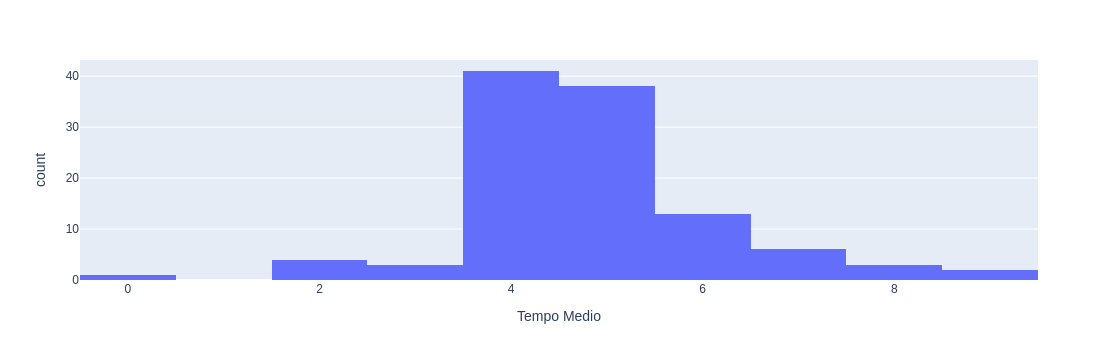

In [504]:
# px.histogram(x, x=var)
# px.histogram(z, x=var)
# px.histogram(y, x=var)
var = z['Tempo Medio']
px.histogram(z, x=var)

In [505]:
var = z['Tempo Medio']
var2 = x['Tempo Medio']

f, p = f_oneway(var, var2)


if p < 0.05:
    print("Reject the null hypothesis: at least one group mean is divergent")
elif p > 0.05:
    print("All group means are the same. Null hypothesis cannot be rejects")

Reject the null hypothesis: at least one group mean is divergent


## Removing irrelevant data 

In [506]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Data Nascimento      664 non-null    object        
 1   Sexo                 664 non-null    object        
 2   Raça                 664 non-null    object        
 3   Estrangeiro          664 non-null    object        
 4   Nacionalidade        664 non-null    object        
 5   Naturalidade         664 non-null    object        
 6   UF Naturalidade      664 non-null    object        
 7   Período              664 non-null    int64         
 8   Situação atual       664 non-null    object        
 9   Data ocorrência      664 non-null    datetime64[ns]
 10  Estrutura            664 non-null    int64         
 11  Período ingresso     664 non-null    int64         
 12  Tipo ingresso        664 non-null    object        
 13  IMI                  664 non-null  

In [507]:
df_to_train = df.drop(columns={"rga_anonimo",
                               "Nacionalidade",
                               "Estrangeiro",
                               "Data Nascimento",
                               "Estrutura",
                               "Data ocorrência",
                               "Período",
                               "Ano Atual"})


In [510]:
# creating just three possible UF locations
class ClassifyOrigin:
    @staticmethod 
    def classify_origin_state(uf):
        if uf in ["MT", "GO"]:
            return uf
        else:
            return "Outsider"
    @staticmethod
    def classify_origin_city(city):
        if city in ["Barra Do Garcas", "Aragarcas", "Goiania", "Brasilia", "Nova Xavantina", "Cuiaba", "Brasilia", "Sao Paulo"]:
            return city 
        else:
            return "Infrequent City"

df_to_train['UF Naturalidade'] = df_to_train['UF Naturalidade'].apply(ClassifyOrigin.classify_origin_state)
df_to_train['Naturalidade'] = df_to_train['Naturalidade'].apply(ClassifyOrigin.classify_origin_city)
df_to_train['AnoEvento'] = df_to_train['AnoEvento'].astype(str).astype(int)


In [511]:
df_to_train_final = pd.get_dummies(df_to_train, 
                                   columns=["Sexo", 
                                            "Raça", 
                                            "Naturalidade",
                                            "UF Naturalidade",
                                            "Situação atual",
                                            "Tipo ingresso",
                                            "Tipo de demanda"
                                            ],drop_first=True)


In [521]:
X = df_to_train_final.drop('dataset', axis=1)
not_encoded_y = df_to_train_final['dataset']

X_train_troll, X_test_troll, y_train_troll, y_test_troll = train_test_split(X, not_encoded_y, test_size=0.2, random_state=42)

In [513]:
le = LabelEncoder()
y = le.fit_transform(not_encoded_y)
print(list(le.classes_))

['Active', 'Deactive', 'Finished']


In [514]:

X = df_to_train_final.drop('dataset', axis=1)

# Selecionar as 5 melhores features
selector = SelectKBest(score_func=f_regression, k=7)
X_new = selector.fit_transform(X, y)

# Ver as features selecionadas
selected_features = selector.get_feature_names_out(input_features=X.columns)
print("As 5 melhores features selecionadas pelo método de filtragem:")
print(selected_features)

As 5 melhores features selecionadas pelo método de filtragem:
['Período ingresso' 'Ano Ingresso' 'AnoEvento' 'total_passes'
 'total_subjects_made' 'Situação atual_EXCLUSAO POR CONCLUSAO (FORMADO)'
 'Situação atual_MATRICULADO NO PERÍODO']


In [515]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [516]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

Random Forest's acurracy: 99.25%

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.99      1.00      0.99        66
           2       1.00      0.97      0.98        30

    accuracy                           0.99       133
   macro avg       1.00      0.99      0.99       133
weighted avg       0.99      0.99      0.99       133


Confusion Matrix


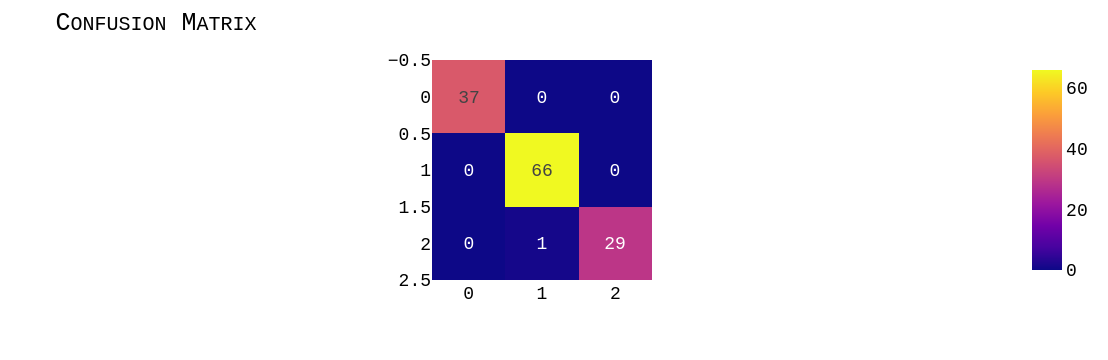

In [517]:
accuracy_rf = accuracy_score(y_test, preds)
print(f"Random Forest's acurracy: {accuracy_rf*100:.2f}%")

print("\nClassification report")
print(classification_report(y_test, preds))

print("\nConfusion Matrix")
cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "Confusion Matrix"}, font=my_font).show()


Logistic Regression's acurracy: 99.25%

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        66
           2       1.00      1.00      1.00        30

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133


Confusion Matrix


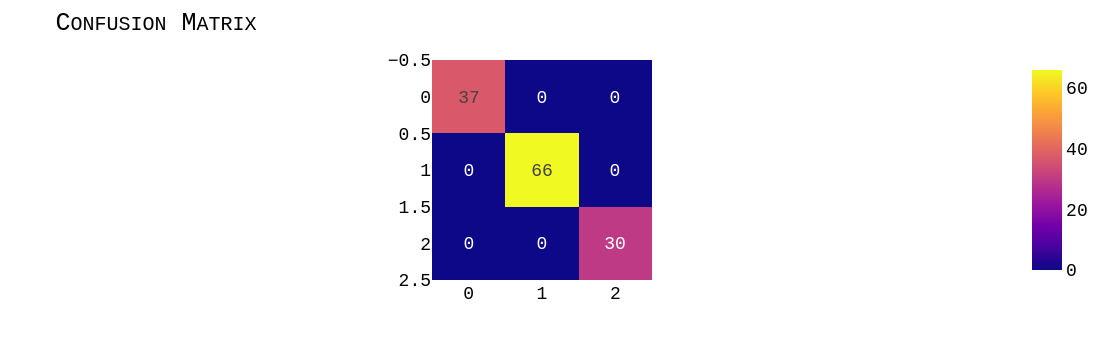

In [518]:
# as recommended, scaling the data increases overall performance 
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
preds = lr.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, preds)
print(f"Logistic Regression's acurracy: {accuracy_rf*100:.2f}%")

print("\nClassification report")
print(classification_report(y_test, preds))

print("\nConfusion Matrix")
cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "Confusion Matrix"}, font=my_font).show()


In [519]:

model = CatBoostClassifier(
    iterations=100,      
    learning_rate=0.1,   
    depth=6,              
    verbose=0             
)

model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy_catboost = accuracy_score(y_test, preds)
print(f"Catboost's acurracy: {accuracy_catboost*100:.2f}%")

print("\nClassification report")
print(classification_report(y_test, predictions))

Catboost's acurracy: 100.00%

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        66
           2       1.00      1.00      1.00        30

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133



In [523]:
# Did not 
model = CatBoostClassifier(
    iterations=100,      
    learning_rate=0.05,   
    depth=6,              
    verbose=0             
)

model.fit(X_train_troll, y_train_troll)

preds = model.predict(X_test_troll)
accuracy_catboost = accuracy_score(y_test_troll, preds)
print(f"Catboost's acurracy: {accuracy_catboost*100:.2f}%")

print("\nClassification report")
print(classification_report(y_test_troll, preds))


Catboost's acurracy: 100.00%

Classification report
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00        37
    Deactive       1.00      1.00      1.00        66
    Finished       1.00      1.00      1.00        30

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133

